In [1]:
import pickle
import numpy as np
import torch
from torch import nn
import copy
import math
import matplotlib.pyplot as plt
import random
import torch.nn.init as init
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F
import warnings
from copy import copy
from torch.utils.data import random_split
import gc
warnings.filterwarnings("ignore")
def show_images(data, num_samples=1, cols=1):
    if isinstance(data, torchvision.datasets.ImageFolder):
        plt.figure(figsize=(15,15))
        for i, img in enumerate(data):
            if i == num_samples:
                break
            plt.subplot(num_samples/cols+1, cols, i+1)
            plt.imshow(img[0], color='red')

def show_tensor_image(image):
    if len(image.shape) == 4:
        image = image[0]
    image = torch.clamp(image, -1, 1)
    plt.imshow(image.squeeze(0))

In [2]:
T = 150
max_octaves = 8
sequence_length = 64
device = torch.device("cuda")

#####################
def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)

def cosine_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    t = torch.linspace(0, 1, timesteps)
    return start + (end - start) * (1 - (1 + torch.cos(np.pi * t)) / 2)

betas = cosine_beta_schedule(timesteps=T).cuda()

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0).cuda()
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0).cuda()
sqrt_recip_alphas = torch.sqrt(1.0 / alphas).cuda()
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).cuda()
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod).cuda()
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod).cuda()    

def deformat_time(input):
        input = torch.tensor(input) 
        return torch.clamp(input*2000, 0)
def format_time(input):
        return input/2000
    

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cuda())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device ="cuda"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    return sqrt_alphas_cumprod_t.to(device)*x_0.to(device) + \
sqrt_one_minus_alphas_cumprod_t.to(device)*noise.to(device), noise.to(device) 


class Embedding(nn.Module):
    def __init__(self, in_shape, emb_shape):
        super().__init__()
        self.sems = 12
        self.octs = max_octaves
        self.sem_shape = emb_shape - 1
        self.emb_shape = emb_shape
    
        self.sem_embedding = nn.Sequential(nn.Linear(in_shape-1, self.sem_shape), nn.SiLU(),
                                        nn.Linear(self.sem_shape, self.sem_shape), nn.Tanh())
        
        self.sem_decoder = nn.Sequential(nn.Linear(self.sem_shape, self.sem_shape), nn.SiLU(),
                                        nn.Linear(self.sem_shape, in_shape-1), nn.SiLU())
        
    def encoder(self, input):
        encoded_sem = self.sem_embedding(input[..., :-1])
        return torch.cat((encoded_sem, input[..., -1:]), dim=-1)
    
    def decoder(self, input):
        decoded_sem = self.sem_decoder(input[..., :-1]).to(device)
        return torch.cat((decoded_sem, input[..., -1:]), dim=-1)
        
    def fit(self, target_loss):
        optim = torch.optim.Adam(self.parameters(), lr=0.00025)
        N = 256
        while True:
            one_hot1 = torch.eye(self.sems)
            one_hot2 = torch.eye(self.octs)
            random_values = torch.rand(N, 1)
            random_values[N//2:] *= 0.3
            random_values = format_time(random_values*2500)
            random_values[:N//4] = 0
            input = torch.cat([one_hot1[torch.randint(0, self.sems, (N,))] , one_hot2[torch.randint(0, self.octs, (N,))], random_values], dim=1)
            input = input.unsqueeze(0).to(device)
            out = self.decoder(self.encoder(input))
            loss = nn.functional.mse_loss(input, out)
            loss.backward()
            optim.step()
            optim.zero_grad()
            print(loss.item())
            if loss.item() < target_loss:
                torch.save(self.state_dict(), "./modeldata/embedding")
                break
                
embedding = Embedding(13+max_octaves, 12).to(device)
#embedding.fit(0.00005)
emb_state_dict = torch.load("./modeldata/embedding")
embedding.load_state_dict(emb_state_dict)
embedding.to(device)

for param in embedding.parameters():
    param.requires_grad = False

In [3]:
skip_count = [0,0,0]   

class NoteDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, sequence_length = 128):
        training_data = pickle.load(open(data_path, 'rb'))
        self.sequence_length = sequence_length
        
        for n, track in enumerate(training_data):
            i=0
            while i < len(track[1])-1:
                time_diff = track[1][i+1]["start"] - track[1][i]["start"]
                rev_time_diff = track[1][i]["start"] - track[1][i-1]["start"]
                notes_the_same = track[1][i]["notes"] == track[1][i+1]["notes"]
                rev_notes_the_same = track[1][i]["notes"] == track[1][i-1]["notes"]
                if (time_diff < 50. and notes_the_same) or (rev_time_diff < 50. and rev_notes_the_same) or (int(time_diff) in range(1,65) or time_diff < 0.):

                    training_data[n][1].remove(training_data[n][1][i])
                    skip_count[0] += 1
                else:
                    i+=1
        
        for track in training_data:
            for i in reversed(range(len(track[1]))):
                time_diff = track[1][i]["start"] - track[1][i-1]["start"]
                track[1][i]["start"] = 0 if (i==0 or -1 < time_diff < 0) else int(time_diff)
           
        self.data = []
        self.band_idx = []#name i stores data i name
        self.bands = []#band list
        
        def extract_data(start_index = 0):
            for track in training_data:
                sequence_ind = 0
                sequence_data = []
                track[1] = track[1][start_index:]
                for beat in track[1]:
                    if  beat["start"] < 0:
                        skip_count[1] += 1
                        continue
                    new_elements = beat["notes"]
                    for note in new_elements:
                        if note[1] > (max_octaves-1):
                            skip_count[2] += 1
                            continue
                        new_data_point = [[0 for i in range(12)], [0 for i in range(max_octaves)]]
                        new_data_point[0][note[0]], new_data_point[1][note[1]] = 1, 1
                        new_data_point = new_data_point[0] + new_data_point[1]
                        new_data_point.append(min(beat["start"], 2500))
                        sequence_data.append(new_data_point) 
                        sequence_ind+=1
                        if sequence_ind == sequence_length:
                            self.data.append(sequence_data)
                            if track[0] not in self.bands:
                                self.bands.append(track[0])
                            self.band_idx.append(self.bands.index(track[0]))
                            sequence_data = []
                            sequence_ind = 0
                            
        extract_data()
        extract_data(sequence_length//2)
        
        self.data = torch.tensor(self.data, dtype=torch.float32).to(device)
        pickle.dump(self.bands, open("./modeldata/bands", 'wb'))
        
        print("skipped:", skip_count, "total_bands:", len(self.bands))
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        rnd = (torch.rand(1).to(device)*-0.25) + 1.
        data = self.data[idx].clone()
        data[:, -1] = format_time(data[:,-1]*rnd)
        return data, self.bands[self.band_idx[idx]]
    
class SelfAttention(nn.Module): #attends token to token
    def __init__(self, channels, size1, size2, num_heads = 4, emb_dim=32):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size1 = size1
        self.size2 = size2
        self.hidden_dim = channels*size2
        self.mha = nn.MultiheadAttention(self.hidden_dim, num_heads, batch_first=True)
        self.ff_self = nn.Sequential(
            nn.LayerNorm([self.hidden_dim]),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
        )
        
        self.emb_layer = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, channels))

    def forward(self, x, emb=0):
        if type(emb) != int:
            emb = self.emb_layer(emb)[(..., ) + (None, ) * 2]
            
        x = (x+emb).swapaxes(1, 2).reshape(-1, self.size1, self.hidden_dim)
        attention_value, _ = self.mha(x, x, x)
        

        
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value 
        return attention_value.reshape(-1, self.size1, self.channels, self.size2).swapaxes(1, 2)
    
"""
class SelfAttention(nn.Module):
    def __init__(self, channels, size1, size2, num_heads = 4):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size1 = size1
        self.size2 = size2
        self.mha = nn.MultiheadAttention(channels, num_heads, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size1 * self.size2).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size1, self.size2)
    
"""    

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False, pad=1, stride = 1):
        super().__init__()
        if mid_channels == None:
            mid_channels = out_channels
        self.residual = residual
        
        self.double_conv = nn.Sequential(nn.Conv2d(in_channels, mid_channels, 3, padding = pad, stride=stride, bias = False),
                                         nn.GroupNorm(1, mid_channels),
                                         nn.GELU(),
                                         nn.Conv2d(mid_channels, out_channels, 3, padding = pad, stride=stride, bias = False),
                                         nn.GroupNorm(1, out_channels))
        
    def forward(self, x):
        if self.residual:
            return F.gelu(self.double_conv(x)+x)
        else:
            return self.double_conv(x)
        
class ConditionalDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False, pad=1, stride = 1, emb_dim=32):
        super().__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, mid_channels, residual, pad, stride)
        
        self.emb_layer = nn.Sequential(nn.SiLU(),
                                       nn.Linear(emb_dim, out_channels))
        
    def forward(self, x, cond):
        x = self.double_conv(x)
        emb = self.emb_layer(cond)[(..., ) + (None, ) * 2]
        return x + emb
        
        
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=32, pad=1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual = True, pad=pad),
            DoubleConv(in_channels, out_channels, pad=pad)
            
        )
        
        self.emb_layer = nn.Sequential(nn.SiLU(),
                                       nn.Linear(emb_dim, out_channels))
    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[(..., ) + (None, ) * 2]
        return x + emb
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=32):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode="bilinear", align_corners = True)
        self.conv = nn.Sequential(DoubleConv(in_channels, in_channels, residual = True),
                                 DoubleConv(in_channels, out_channels, in_channels // 2))
        
        self.emb_layer = nn.Sequential(nn.SiLU(),
                                       nn.Linear(emb_dim, out_channels))
    def forward(self, x, skip_x, t):
                                
        x = self.up(x)
        x = torch.cat([x, skip_x], dim = 1)
        x = self.conv(x)
        emb = self.emb_layer(t)[(..., ) + (None, ) * 2]
        return x + emb
        
class TimeAndBandEmbedding(nn.Module):
    def __init__(self, dim_t, dim_b):
        super().__init__()
        self.dim_t = dim_t
        self.dim_b = dim_b
        self.bands_list = pickle.load(open("./modeldata/bands", 'rb'))
        self.band_compressor = nn.Sequential(nn.Linear(len(self.bands_list), self.dim_b), 
                                             nn.SiLU())

    def forward(self, time, bands):
        band_id = F.one_hot(torch.tensor([self.bands_list.index(b) for b in bands]).to("cuda"), len(self.bands_list)).to(torch.float)
        half_dim_t = self.dim_t // 2
        embeddings_t = math.log(10000) / (half_dim_t - 1)
        embeddings_t = torch.exp(torch.arange(half_dim_t, device=device) * -embeddings_t)
        embeddings_t = time[:, None] * embeddings_t[None, :]
        embeddings_t = torch.cat((embeddings_t.sin(), embeddings_t.cos()), dim=-1)
        embeddings_b = self.band_compressor(band_id)
        return torch.cat((embeddings_t, embeddings_b), dim=-1)


class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=26, band_dim = 6):
        super().__init__()
        self.encoding = TimeAndBandEmbedding(time_dim, band_dim)
        self.b_d = band_dim
        seq = sequence_length
        embed_dim = time_dim + band_dim

        self.inc = DoubleConv(c_in, 32)     
        self.down1 = Down(32, 64, embed_dim) 
        self.sa1 = SelfAttention(64, seq//2, 6, 4,embed_dim)
        self.down2 = Down(64, 128, embed_dim)  
        self.sa2 = SelfAttention(128, seq//4, 3, 4,embed_dim) 
 
        self.bot1 = ConditionalDoubleConv(128, 128, emb_dim=embed_dim)
        self.bottleneck_attention = [SelfAttention(128, seq//4, 3, 8 ,embed_dim).to(device) for i in range(4)]
        self.bot2 = ConditionalDoubleConv(128, 128, emb_dim=embed_dim) 
        
        self.up1 = Up(192, 128, embed_dim) 
        self.sa3 = SelfAttention(128, seq//2, 6, 4,embed_dim)
        self.up2 = Up(160, 64, embed_dim)
        self.sa4 = SelfAttention(64, seq, 12, 4, embed_dim)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                
    def sab(self, x, cond):
        for a in self.bottleneck_attention:
            x = a(x, cond)
        return x
    
    def forward(self, x, t, b):
        
        cond = self.encoding(t, b)

        x1 = self.inc(x)
        x2 = self.down1(x1, cond)
        x2 = self.sa1(x2,cond)
        x3 = self.down2(x2, cond)
        x3 = self.sa2(x3,cond)
        
        x3 = self.bot1(x3, cond)
        x3 = self.sab(x3,cond)
        x3 = self.bot2(x3, cond)
        
        x = self.up1(x3, x2, cond)
        x = self.sa3(x,cond)     
        x = self.up2(x, x1, cond)
        x = self.sa4(x,cond)
        output = self.outc(x)
        return output      
    
def get_loss_comps(model, x_0, t, bands):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t, bands)
    return noise, noise_pred

@torch.no_grad()
def sample_timestep(x,t,b,temp):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
   
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, b) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise * temp
    
@torch.no_grad()
def generate(b, start_temp, end_temp, img=None, context=0):
    model.eval()
    if img is None:
        img = torch.randn((1, 1, sequence_length, embedding.emb_shape), device=device)

        
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 5
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        temp = start_temp + (end_temp-start_temp)*(i/T)
        img[:,:,context:] = sample_timestep(img, t, [b], temp)[:,:,context:] 
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()
    model.train()
    return img
    

def generate_sequence(b, start_temp, end_temp, number, context):
    seq = generate(b, start_temp, end_temp)
    for i in range(number-1):
        new = seq.clone()[:, :,-context:]
        new = torch.cat((new, torch.randn((1, 1, sequence_length-context, embedding.emb_shape), device=device)), dim = 2)
        new = generate(b, start_temp, end_temp, new, context)[:,:,context:]
        seq = torch.cat((seq,new),dim=2)
    return seq
        
    
def prediction(input, k=1):
    input = input.squeeze(0).squeeze(0)
    sems = torch.tensor(torch.topk(input[:, :12], dim=-1, k=k).indices[:, k-1]).unsqueeze(1)
    octs =  torch.tensor(torch.topk(input[:, 12:-1], dim=-1, k=k).indices[:, k-1]).unsqueeze(1)
    times = input[:, -1].unsqueeze(-1)
    return torch.cat((sems,octs,deformat_time(times)), dim = -1).to(torch.int).to("cpu").detach().numpy()

def prediction2(input):
    input = input.squeeze(0).squeeze(0)
    sems = torch.tensor(input[:, :12].argmax(dim=-1)).unsqueeze(1)
    octs =  torch.tensor(input[:,12:12+max_octaves].argmax(dim=-1)).unsqueeze(1)
    print(octs.shape)
    times = input[:, -1].unsqueeze(-1)
    return torch.cat((sems,octs,deformat_time(times)), dim = -1).to(torch.int).to("cpu").detach().numpy()

def group_times(input, num_groups, coeff, clamp, make_time_constant):
    if make_time_constant["value"] != -1:
        out = input.copy()
        out[:, -1] = make_time_constant["value"]
        mask = input[:, -1] < make_time_constant["threshold"]
        out[mask, -1] = 0
        return out
    times = input[:, -1].flatten()
    times[times>clamp] = clamp
    value_range = max(times) - min(times)
    bin_size = value_range / num_groups
    groups = [int((time - min(times)) //bin_size )for time in times]
    
    mean_per_group = [[] for i in range(num_groups+1)]
    for g, t in enumerate(times):
        mean_per_group[int(groups[g])].append(t)
    
    mean_per_group = [sum(e)/len(e) if len(e)!= 0 else 0 for e in mean_per_group] 
    corrected_ts = [mean_per_group[i] for i in groups]
    out = [np.append(elem[:-1],int(corrected_ts[i]*coeff)) for i, elem in enumerate(input)]
    return out

    


In [4]:
batch_size = 128
def lr_lambda(epoch, max_epochs, max_lr, initial_lr, final_lr, warmup_epochs):
    
    if epoch < warmup_epochs:
        return (max_lr - initial_lr) / warmup_epochs * epoch + initial_lr
    else:
        return (final_lr + 0.5 * (max_lr - final_lr) *
                (1 + np.cos((epoch - warmup_epochs) / (max_epochs - warmup_epochs) * np.pi)))

max_epochs = 500
max_lr = 10**(-3.8)
initial_lr = 10**(-6)
final_lr = 10**(-8)
warmup_epochs = 5
""""""
dataset = NoteDataset(data_path = "./preprocessed_data/data", sequence_length = sequence_length)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


model = UNet(c_in=1, c_out=1, time_dim=30, band_dim = 2).to(device)
#net_state_dict = torch.load("./modeldata/model")
#model.load_state_dict(net_state_dict) 
optim = torch.optim.Adam(model.parameters(), lr=1, weight_decay=0.0005)
scheduler = LambdaLR(optim, lr_lambda=lambda epoch: lr_lambda(epoch, max_epochs, max_lr, initial_lr, final_lr, warmup_epochs))

skipped: [247578, 539584, 328] total_bands: 3


In [5]:
#scheduler.step()
#optim = torch.optim.Adam(model.parameters(), lr=10**(-7.5), weight_decay=0.0005)
epochs = 15000

def val():
    model.eval()
    losses = []
    for images, bands in val_loader:
        images = images.unsqueeze(1)
        images = embedding.encoder(images)
        t = torch.randint(0, T, (images.shape[0],), device=device).long()
        target, prediction = get_loss_comps(model, images, t, bands)
        loss = F.mse_loss(prediction, target)
        losses.append(loss.item())
    model.train()
    loss = sum(losses)/len(losses)
    print(f"Validation loss: {loss} ")
    return loss
            
def train():
    for epoch in range(epochs):
        losses = []
        val_losses = [99,99,99]
        for images, bands in data_loader:
            images = images.unsqueeze(1)
            images = embedding.encoder(images)
            optim.zero_grad()
            t = torch.randint(0, T, (images.shape[0],), device=device).long()
            target, prediction = get_loss_comps(model, images, t, bands)
            loss = F.mse_loss(prediction, target)
            losses.append(loss.item())
            loss.backward()
            optim.step()
        scheduler.step()
            
        print(f"Epoch {epoch} | Loss: {sum(losses)/len(losses)} ")
        if epoch % 150 == 0 and epoch != 0:      
            torch.save(model.state_dict(), "./modeldata/modelv2")
        if epoch % 2 == 0 and epoch != 0:      
            val_losses.append(val())
            if val_losses[-1] > val_losses[-2] > val_losses[-3]:
                torch.save(model.state_dict(), "./modeldata/modelv2")
                print("Validation loss increasing")
                break
            
train()   #

Epoch 0 | Loss: 0.3418584893609202 
Epoch 1 | Loss: 0.18151295106540355 
Epoch 2 | Loss: 0.12272417702416116 
Validation loss: 0.11364890744580942 
Epoch 3 | Loss: 0.10579686212216237 
Epoch 4 | Loss: 0.09779609628888064 
Validation loss: 0.09129821662517155 
Epoch 5 | Loss: 0.09100091039210327 
Epoch 6 | Loss: 0.0874077377508777 
Validation loss: 0.08521238670629613 
Epoch 7 | Loss: 0.08490214916162712 
Epoch 8 | Loss: 0.08287128962056581 
Validation loss: 0.0808010611902265 
Epoch 9 | Loss: 0.08108336316753728 
Epoch 10 | Loss: 0.08016027264123739 
Validation loss: 0.0798826121232089 
Epoch 11 | Loss: 0.07867599550143693 
Epoch 12 | Loss: 0.07770243212003117 
Validation loss: 0.07842105648973409 
Epoch 13 | Loss: 0.07717191878446313 
Epoch 14 | Loss: 0.07607407032750374 
Validation loss: 0.07516875402892337 
Epoch 15 | Loss: 0.07517355286566786 
Epoch 16 | Loss: 0.07396606905746829 
Validation loss: 0.07181819747476016 
Epoch 17 | Loss: 0.07346290544599526 
Epoch 18 | Loss: 0.0724754

KeyboardInterrupt: 

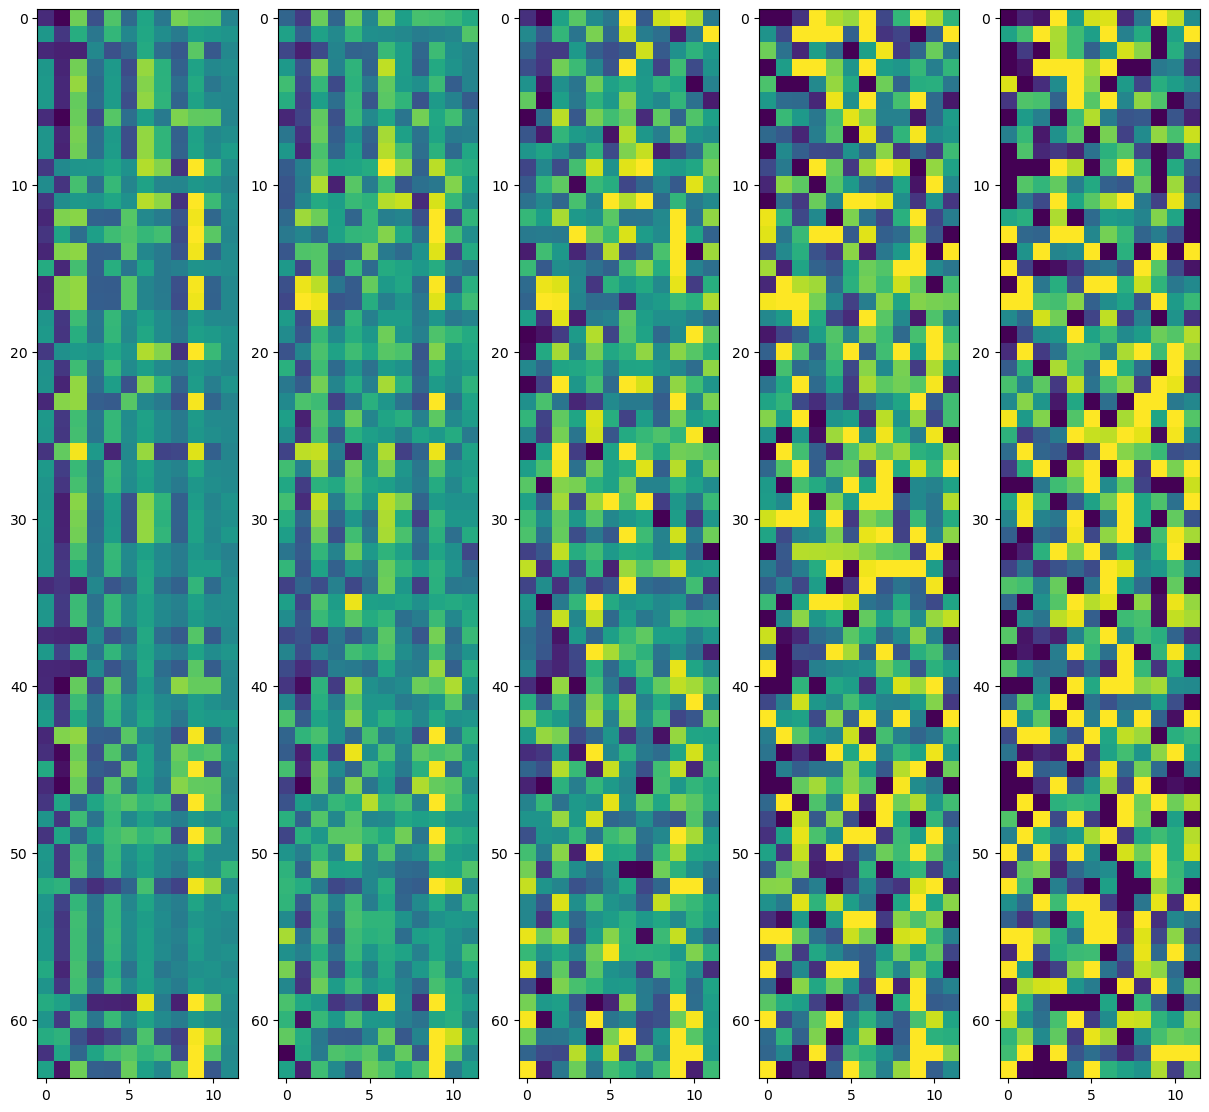

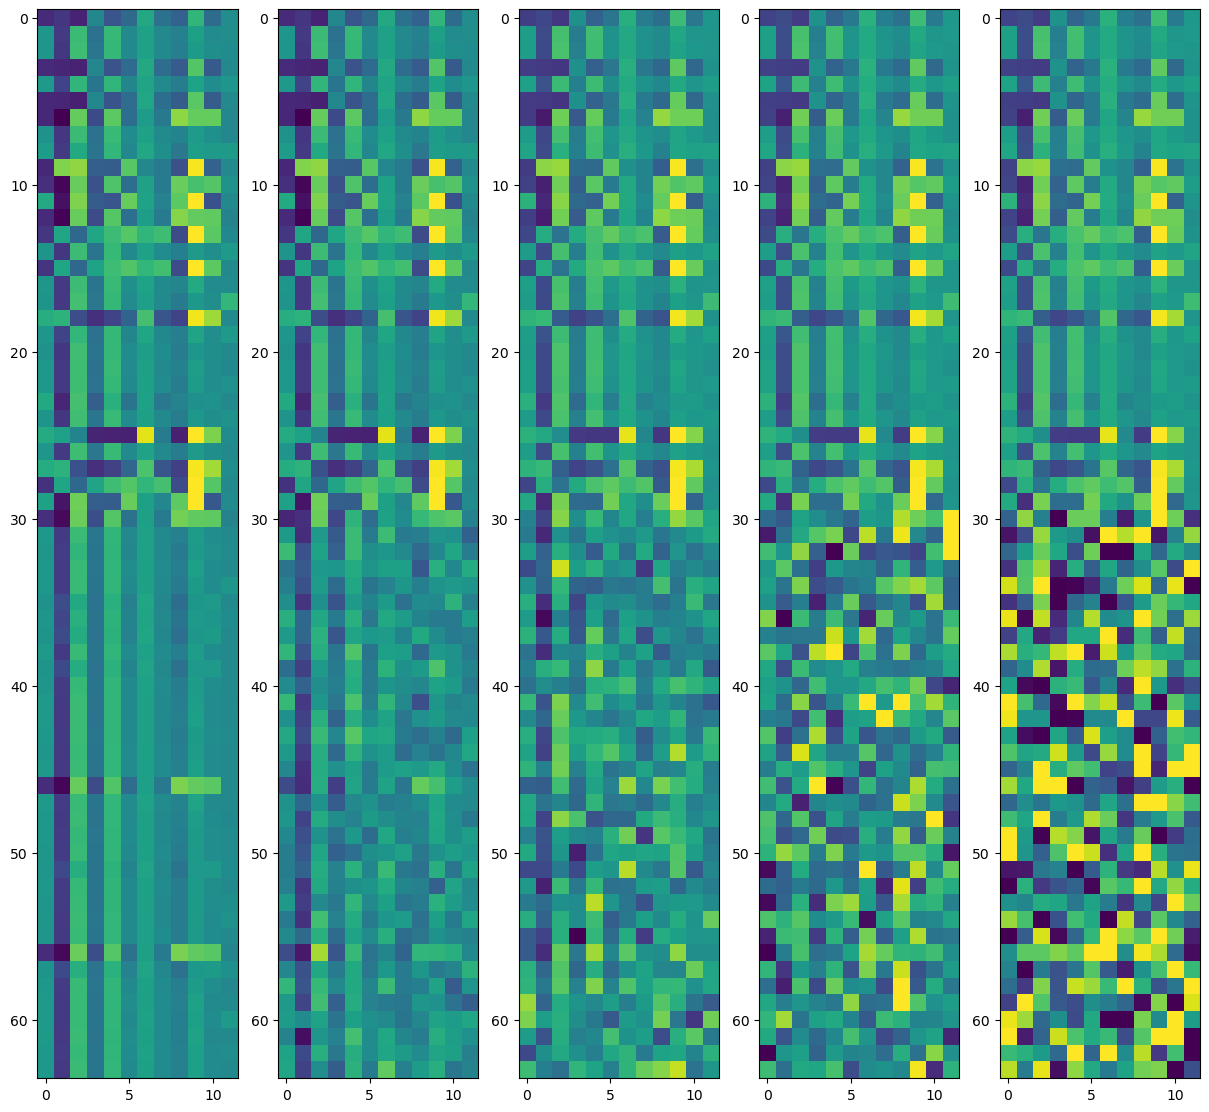

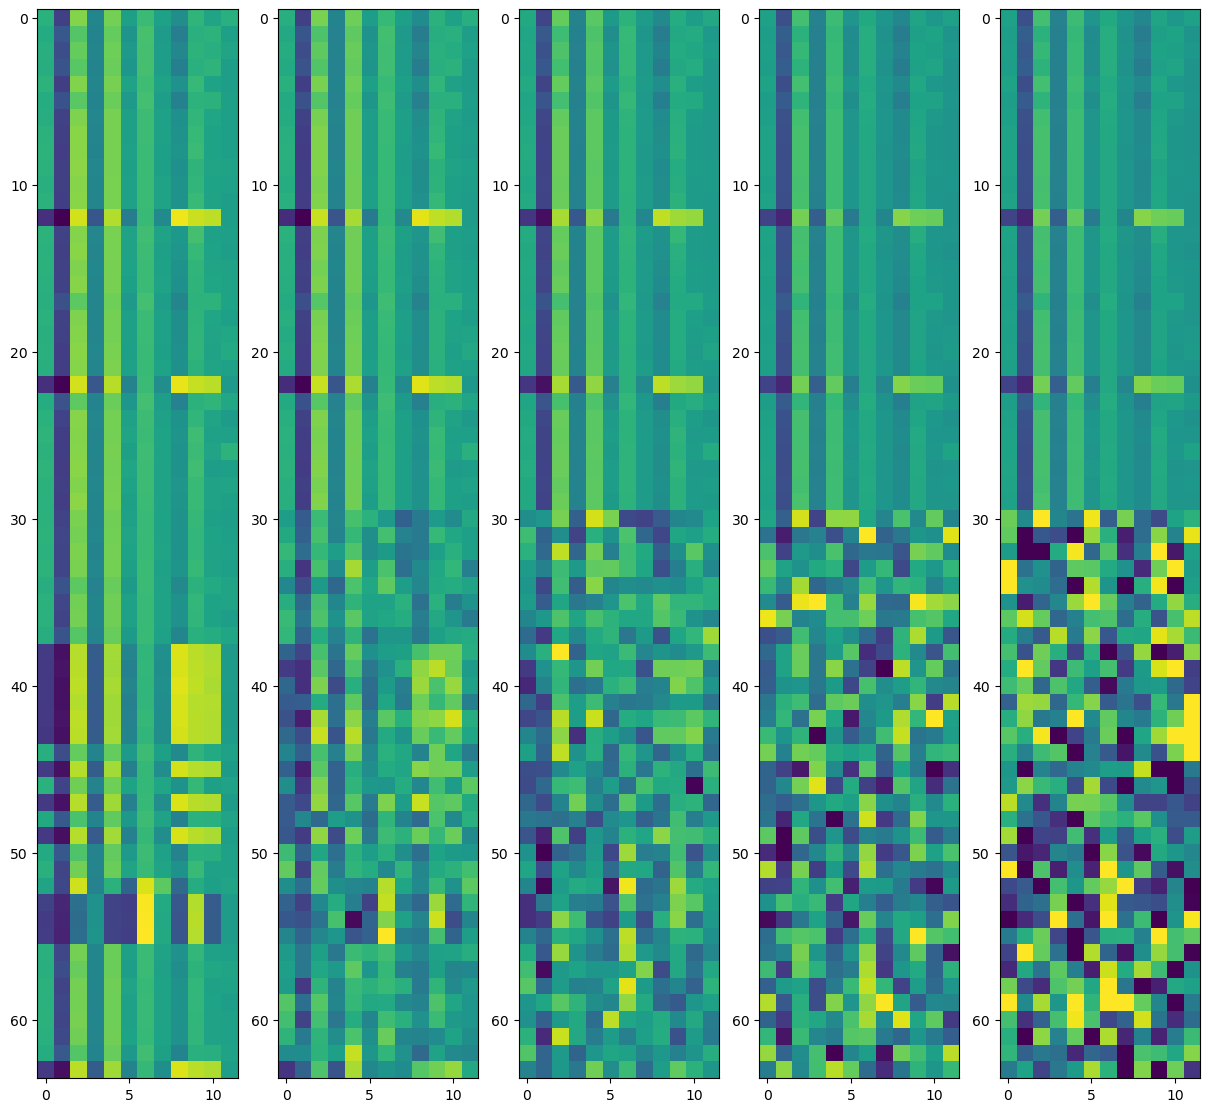

torch.Size([132, 1])


In [37]:
pred = generate_sequence("tech", start_temp=1, end_temp=1, number=3, context=30) #context < sequence_length
pred = embedding.decoder(pred)
pred = prediction2(pred)


In [38]:
out = group_times(pred, num_groups=1, coeff=1, clamp=600, 
                  make_time_constant = {"value": 120, "threshold": 0}) #if make_time_constant["value"]!=-1 replaces all times, except those below threshold, which are set to 0
#out = pred                                                                                                    
with open("./outputs/generated_sequence", "wb") as f:
    pickle.dump(out, f)
out

array([[  0,   6, 120],
       [  3,   6, 120],
       [ 10,   4, 120],
       [  3,   3, 120],
       [  4,   3, 120],
       [  3,   3, 120],
       [  0,   4, 120],
       [  3,   3, 120],
       [  3,   3, 120],
       [  8,   3, 120],
       [  4,   6, 120],
       [  8,   3, 120],
       [  9,   6, 120],
       [  8,   6, 120],
       [  9,   4, 120],
       [  3,   6, 120],
       [  9,   4, 120],
       [  9,   4, 120],
       [  4,   4, 120],
       [  3,   6, 120],
       [  8,   3, 120],
       [  4,   6, 120],
       [  3,   3, 120],
       [  9,   6, 120],
       [  4,   6, 120],
       [  4,   6, 120],
       [  9,   2, 120],
       [  4,   6, 120],
       [  4,   6, 120],
       [  3,   3, 120],
       [  3,   3, 120],
       [  3,   3, 120],
       [  4,   6, 120],
       [  3,   6, 120],
       [ 10,   4, 120],
       [  4,   6, 120],
       [  4,   6, 120],
       [ 10,   4, 120],
       [  3,   6, 120],
       [ 10,   4, 120],
       [  0,   4, 120],
       [  4,   6

In [28]:
torch.save(model.state_dict(), "./modeldata/model")

In [11]:

out = prediction2(dataset.data[13525])
for i in range(len(out)):
    out[i][2] = format_time(out[i][2])
with open("./outputs/generated_sequence", "wb") as f:
    pickle.dump(out, f)
out

torch.Size([128, 1])


array([[  5,   3, 100],
       [  5,   3,  99],
       [  5,   3, 100],
       [  5,   3, 100],
       [  5,   3,  99],
       [  0,   4, 100],
       [ 11,   3, 200],
       [  7,   3, 199],
       [  8,   3, 200],
       [  7,   3, 200],
       [  6,   3, 400],
       [  6,   3, 100],
       [  6,   3,  99],
       [  6,   3, 100],
       [  6,   3,  99],
       [  6,   3, 100],
       [  6,   3, 100],
       [  6,   3,  99],
       [  2,   4, 100],
       [  8,   3, 200],
       [  5,   3, 199],
       [  5,   3, 100],
       [  5,   3,  99],
       [  5,   3, 100],
       [  5,   3, 100],
       [  5,   3,  99],
       [  5,   3, 100],
       [  5,   3,  99],
       [  2,   4, 100],
       [  8,   3, 199],
       [  7,   3, 200],
       [  6,   3, 200],
       [  0,   4, 200],
       [  6,   3, 399],
       [  6,   3, 100],
       [  6,   3,  99],
       [  6,   3, 100],
       [  6,   3, 100],
       [  6,   3,  99],
       [  6,   3, 100],
       [  6,   3,  99],
       [  2,   4

In [235]:
len(dataset)

86871

In [27]:
import gc

model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()